In [1]:
import matplotlib.pyplot as plt
import numpy as np
from Utils.properties import HAC
from rdkit.Chem import MolFromSmiles
import pandas as pd
import itertools
import os

/home/chaoting/software/miniconda3/envs/py385/lib/python3.8/site-packages/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mcf.append(_pains, sort=True)['smarts'].values]


In [2]:
property_list = ['logP', 'tPSA', 'QED']
trg_prop_settings = {
    'logP': [ 1.0,   2.0,  3.0],
    'tPSA': [30.0,  60.0, 90.0],
    'QED' : [ 0.6, 0.725, 0.85],
}
tol = [0.4, 8, 0.03]

In [3]:
def get_trg_prop_list():
    # get property combinations

    prop_set = (trg_prop_settings[p] for p in property_list)
    prop_comb = list(itertools.product(*prop_set))
    trg_prop_list = [list(c) for c in prop_comb]
    # for i in range(len(trg_prop_list)):
    #     print(i, trg_prop_list[i])
    return trg_prop_list


def add_hac(df):
    mols = list(map(MolFromSmiles, df['scaffold']))
    df['HAC'] = list(map(HAC, mols))
    return df


def get_n_train():
    n_train = []
    a = b = c = 0
    trg_prop_list = get_trg_prop_list()
    train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])

    for i, prop in enumerate(trg_prop_list):
        filtered = train[(prop[0] - tol[0] <= train.logP) & (train.logP <= prop[0] + tol[0])]
        filtered = filtered[(prop[1] - tol[1] <= filtered.tPSA) & (filtered.tPSA <= prop[1] + tol[1])]
        filtered = filtered[(prop[2] - tol[2] <= filtered.QED) & (filtered.QED <= prop[2] + tol[2])]
        n_train.append(len(filtered))
        
        if prop[2] == 0.6:
            a += len(filtered)
        if prop[2] == 0.725:
            b += len(filtered)
        if prop[2] == 0.85:
            c += len(filtered)
    return n_train


def get_average_metric_from_all_models(datatype, prand=0.1):
    file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/psca_sampling/'
    n = 100

    if prand == 0:
        model1 = f'scacvaetfv31-beta0.01-warmup15000-17'
        model2 = f'scacvaetfv32-beta0.01-warmup15000-19'
        model3 = f'scacvaetfv3-beta0.01-warmup15000-17'
    else:
        model1 = f'scacvaetfv31-beta0.01-warmup15000_rand{prand}-20'
        model2 = f'scacvaetfv32-beta0.01-warmup15000_rand{prand}-20'
        model3 = f'scacvaetfv33-beta0.01-warmup15000_rand{prand}-20'
    
    all_met = None
    for sid in np.arange(0, n):
        df_list = []
        for model_name in (model1, model2, model3):
            file_path = os.path.join(file_folder, model_name, datatype, f's{sid}_metric.csv')
            df = pd.read_csv(file_path, index_col=[0])
            scaffold = df['scaffold'].to_list()
            df_numeric = df.select_dtypes(include=['float32', 'float64', 'int32', 'int64'])
            df_list.append(df_numeric)
        
        met = pd.concat(df_list).groupby(level=0).mean()
        met.insert(0, 'scaffold', scaffold)

        if sid == 0:
            all_met = met
        else:
            all_met = pd.concat([all_met, met], axis=0)
    all_met = all_met.reset_index(drop=True)
    all_met = add_hac(all_met)
    return all_met


### Valid and Unique SMILES that fulfill the constraints

In [9]:
rand0 = get_average_metric_from_all_models(datatype='test_scaffolds', prand=0)
rand1 = get_average_metric_from_all_models(datatype='test_scaffolds', prand=0.1)
rand2 = get_average_metric_from_all_models(datatype='test_scaffolds', prand=0.2)
rand3 = get_average_metric_from_all_models(datatype='test_scaffolds', prand=0.3)
rand4 = get_average_metric_from_all_models(datatype='test_scaffolds', prand=0.4)
rand5 = get_average_metric_from_all_models(datatype='test_scaffolds', prand=0.5)

In [10]:
x = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
valid = []
unique = []

for rand in [rand0, rand1, rand2, rand3, rand4, rand5]:
    valid.append(rand['valid_in_tolerance'].mean())
    unique.append(rand['unique_in_tolerance'].mean())

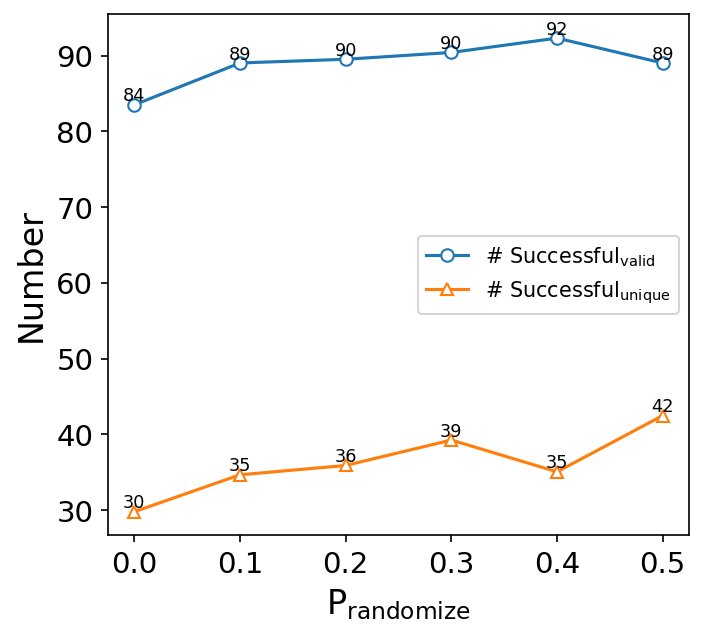

In [13]:
fig, ax = plt.subplots(figsize=(5, 4.6), dpi=150)


ax.plot(x, valid, label=r'# $\mathdefault{Successful}_{\mathdefault{valid}}$', marker='o', markerfacecolor='white')
ax.plot(x, unique, label=r'# $\mathdefault{Successful}_{\mathdefault{unique}}$', marker='^', markerfacecolor='white')

text_size = 8.5
for i in range(len(x)):
    ax.text(x[i], valid[i], f'{valid[i]:.0f}', ha='center', va='bottom', fontsize=text_size)
    ax.text(x[i], unique[i], f'{unique[i]:.0f}', ha='center', va='bottom', fontsize=text_size)
    
plt.xlabel(r'$\mathdefault{P}_{\mathdefault{randomize}}$', fontsize=16)
plt.ylabel('Number', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=10, loc='center right', ncol=1)

plt.show()

In [2]:
rand = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
valid = [0.769, 0.797, 0.775, 0.787, 0.803, 0.754]
unique = [0.395, 0.470, 0.500, 0.516, 0.476, 0.559]
novel = [0.997, 0.998, 0.998, 0.998, 0.997, 0.998]
intdiv = [0.559, 0.585, 0.590, 0.595, 0.571, 0.601]
ssf = [0.627, 0.622, 0.611, 0.613, 0.634, 0.622]

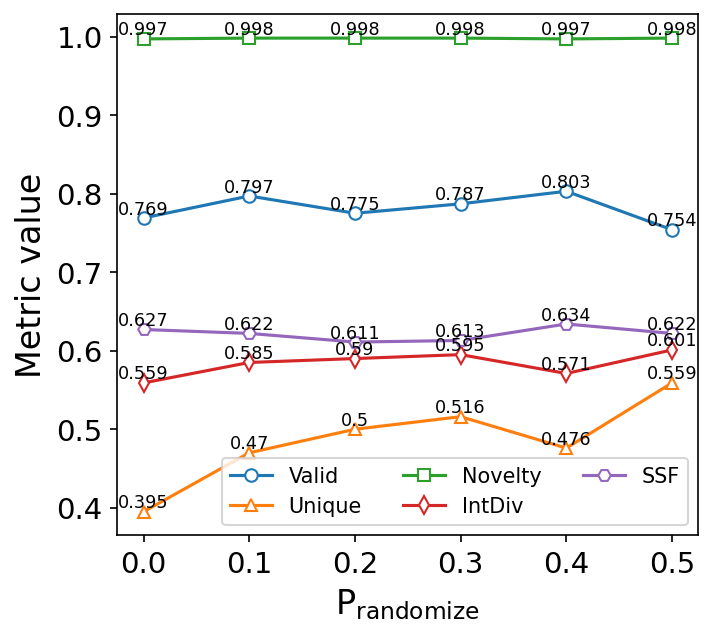

In [43]:

# plt.figure(figsize=(5, 4.6), dpi=150)

fig, ax = plt.subplots(figsize=(5, 4.6), dpi=150)


ax.plot(rand, valid, label='Valid', marker='o', markerfacecolor='white')
ax.plot(rand, unique, label='Unique', marker='^', markerfacecolor='white')
ax.plot(rand, novel, label='Novelty', marker='s', markerfacecolor='white')
ax.plot(rand, intdiv, label='IntDiv', marker='d', markerfacecolor='white')
ax.plot(rand, ssf, label='SSF', marker='H', markerfacecolor='white')


text_size = 8.5
for i in range(len(rand)):
    ax.text(rand[i], valid[i], valid[i], ha='center', va='bottom', fontsize=text_size)
    ax.text(rand[i], unique[i], unique[i], ha='center', va='bottom', fontsize=text_size)
    ax.text(rand[i], novel[i], novel[i], ha='center', va='bottom', fontsize=text_size)
    ax.text(rand[i], intdiv[i], intdiv[i], ha='center', va='bottom', fontsize=text_size)
    ax.text(rand[i], ssf[i], ssf[i], ha='center', va='bottom', fontsize=text_size)
    
plt.xlabel(r'$\mathdefault{P}_{\mathdefault{randomize}}$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=10, loc='lower right', ncol=3)

plt.show()

In [17]:
rand = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

log_range, tpsa_range, qed_range = 0.4, 8, 0.03

log_mse = np.array([0.195, 0.208, 0.116, 0.214, 0.154, 0.191]) / log_range
tpsa_mse = np.array([1.264, 1.389, 2.320, 0.999, 2.561, 2.443]) / tpsa_range
qed_mse = np.array([0.033, 0.027, 0.025, 0.026, 0.029, 0.026]) / qed_range

log_mae = np.array([0.480, 0.484, 0.436, 0.479, 0.444, 0.450]) / log_range
tpsa_mae = np.array([8.140, 7.866, 7.823, 7.457, 7.967, 7.638]) / tpsa_range
qed_mae = np.array([0.094, 0.092, 0.093, 0.093, 0.094, 0.093]) / qed_range

log_sd = np.array([0.407, 0.409, 0.412, 0.413, 0.397, 0.400]) / log_range
tpsa_sd = np.array([7.216, 7.223, 7.123, 7.178, 7.077, 7.202]) / tpsa_range
qed_sd = np.array([0.061, 0.063, 0.065, 0.063, 0.063, 0.065]) / qed_range

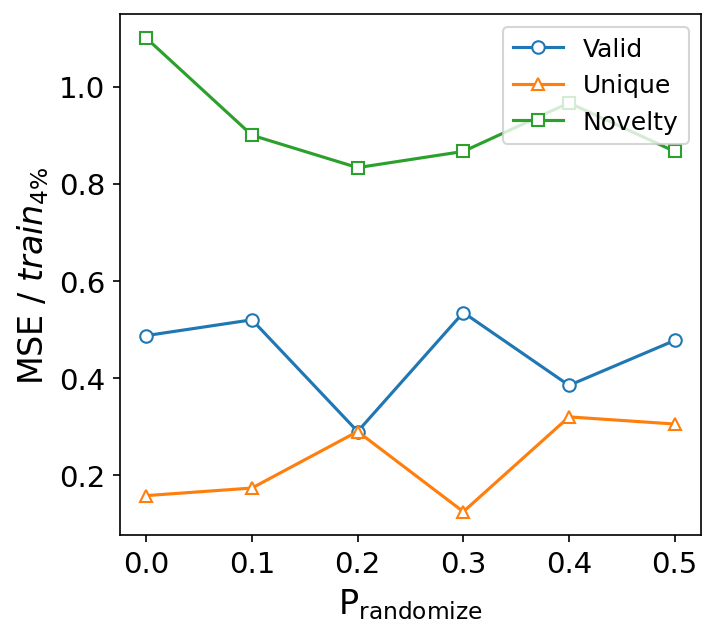

In [41]:
plt.figure(figsize=(5, 4.6), dpi=150)
plt.plot(rand, log_mse, label='Valid', marker='o', markerfacecolor='white')
plt.plot(rand, tpsa_mse, label='Unique', marker='^', markerfacecolor='white')
plt.plot(rand, qed_mse, label='Novelty', marker='s', markerfacecolor='white')

plt.xlabel(r'$\mathdefault{P}_{\mathdefault{randomize}}$', fontsize=16)
plt.ylabel(r'MSE / $train_{4\%}$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc='upper right')

plt.show()

In [20]:
log_mse = np.array([0.195, 0.208, 0.116, 0.214, 0.154, 0.191]) / log_range
tpsa_mse = np.array([1.264, 1.389, 2.320, 0.999, 2.561, 2.443]) / tpsa_range
qed_mse = np.array([0.033, 0.027, 0.025, 0.026, 0.029, 0.026]) / qed_range

log_mae = np.array([0.480, 0.484, 0.436, 0.479, 0.444, 0.450]) / log_range
tpsa_mae = np.array([8.140, 7.866, 7.823, 7.457, 7.967, 7.638]) / tpsa_range
qed_mae = np.array([0.094, 0.092, 0.093, 0.093, 0.094, 0.093]) / qed_range

log_sd = np.array([0.407, 0.409, 0.412, 0.413, 0.397, 0.400]) / log_range
tpsa_sd = np.array([7.216, 7.223, 7.123, 7.178, 7.077, 7.202]) / tpsa_range
qed_sd = np.array([0.061, 0.063, 0.065, 0.063, 0.063, 0.065]) / qed_range

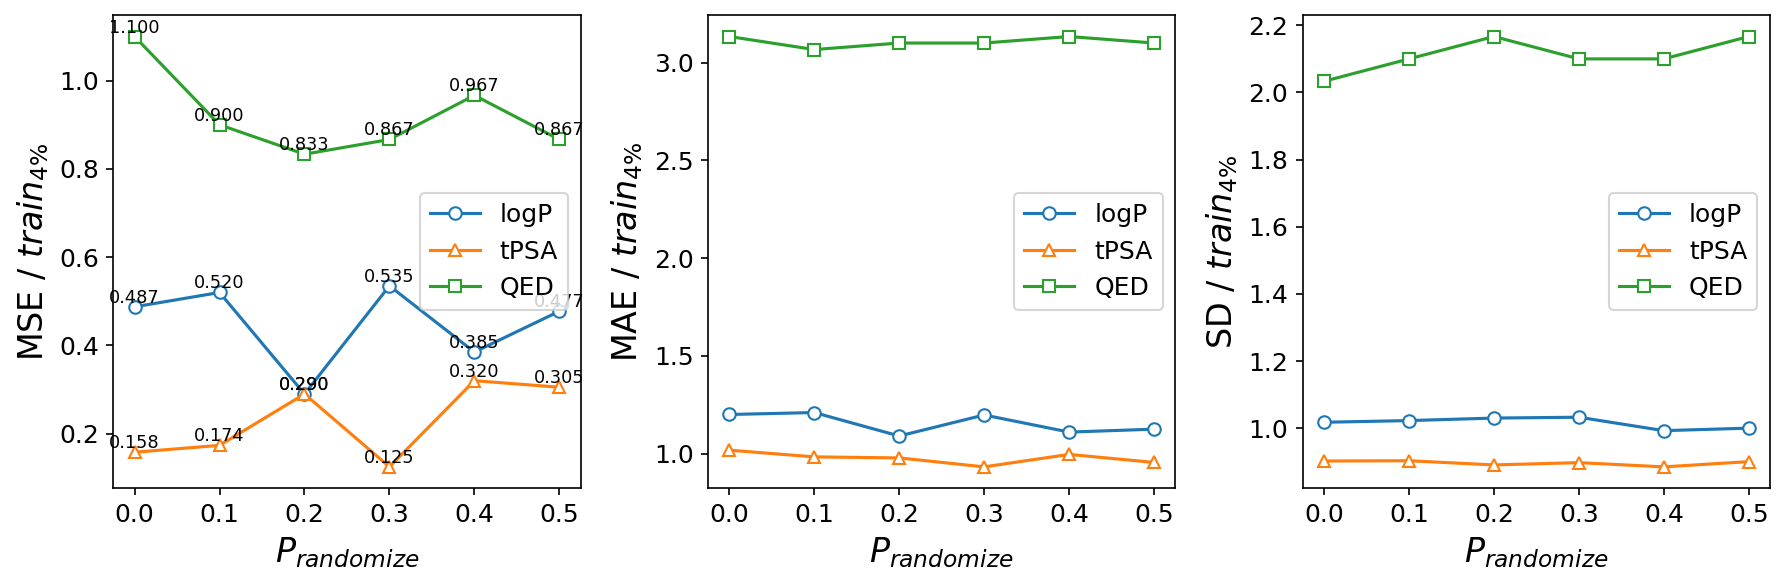

In [24]:
# Data for the line plots
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)

# Create the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

# Plot the line plots in the first subplot
ax1.plot(rand, log_mse, label='logP', marker='o', markerfacecolor='white')
ax1.plot(rand, tpsa_mse, label='tPSA', marker='^', markerfacecolor='white')
ax1.plot(rand, qed_mse, label='QED', marker='s', markerfacecolor='white')
ax1.set_xlabel(r'$P_{randomize}$', fontsize=16)
ax1.set_ylabel(r'MSE / $train_{4\%}$', fontsize=16)
ax1.tick_params(axis='both', which='both', labelsize=12)
ax1.legend(fontsize=12)

# Plot the line plots in the second subplot
ax2.plot(rand, log_mae, label='logP', marker='o', markerfacecolor='white')
ax2.plot(rand, tpsa_mae, label='tPSA', marker='^', markerfacecolor='white')
ax2.plot(rand, qed_mae, label='QED', marker='s', markerfacecolor='white')
ax2.set_xlabel(r'$P_{randomize}$', fontsize=16)
ax2.set_ylabel(r'MAE / $train_{4\%}$', fontsize=16)
ax2.tick_params(axis='both', which='both', labelsize=12)
ax2.legend(fontsize=12)

# Plot the line plots in the third subplot
ax3.plot(rand, log_sd, label='logP', marker='o', markerfacecolor='white')
ax3.plot(rand, tpsa_sd, label='tPSA', marker='^', markerfacecolor='white')
ax3.plot(rand, qed_sd, label='QED', marker='s', markerfacecolor='white')
ax3.set_xlabel(r'$P_{randomize}$', fontsize=16)
ax3.set_ylabel(r'SD / $train_{4\%}$', fontsize=16)
ax3.tick_params(axis='both', which='both', labelsize=12)
ax3.legend(fontsize=12)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [12]:
log_mse = np.array([0.195, 0.208, 0.116, 0.214, 0.154, 0.191])
tpsa_mse = np.array([1.264, 1.389, 2.320, 0.999, 2.561, 2.443])
qed_mse = np.array([0.033, 0.027, 0.025, 0.026, 0.029, 0.026])

log_mae = np.array([0.480, 0.484, 0.436, 0.479, 0.444, 0.450])
tpsa_mae = np.array([8.140, 7.866, 7.823, 7.457, 7.967, 7.638]) 
qed_mae = np.array([0.094, 0.092, 0.093, 0.093, 0.094, 0.093]) 

log_sd = np.array([0.407, 0.409, 0.412, 0.413, 0.397, 0.400]) 
tpsa_sd = np.array([7.216, 7.223, 7.123, 7.178, 7.077, 7.202])
qed_sd = np.array([0.061, 0.063, 0.065, 0.063, 0.063, 0.065])

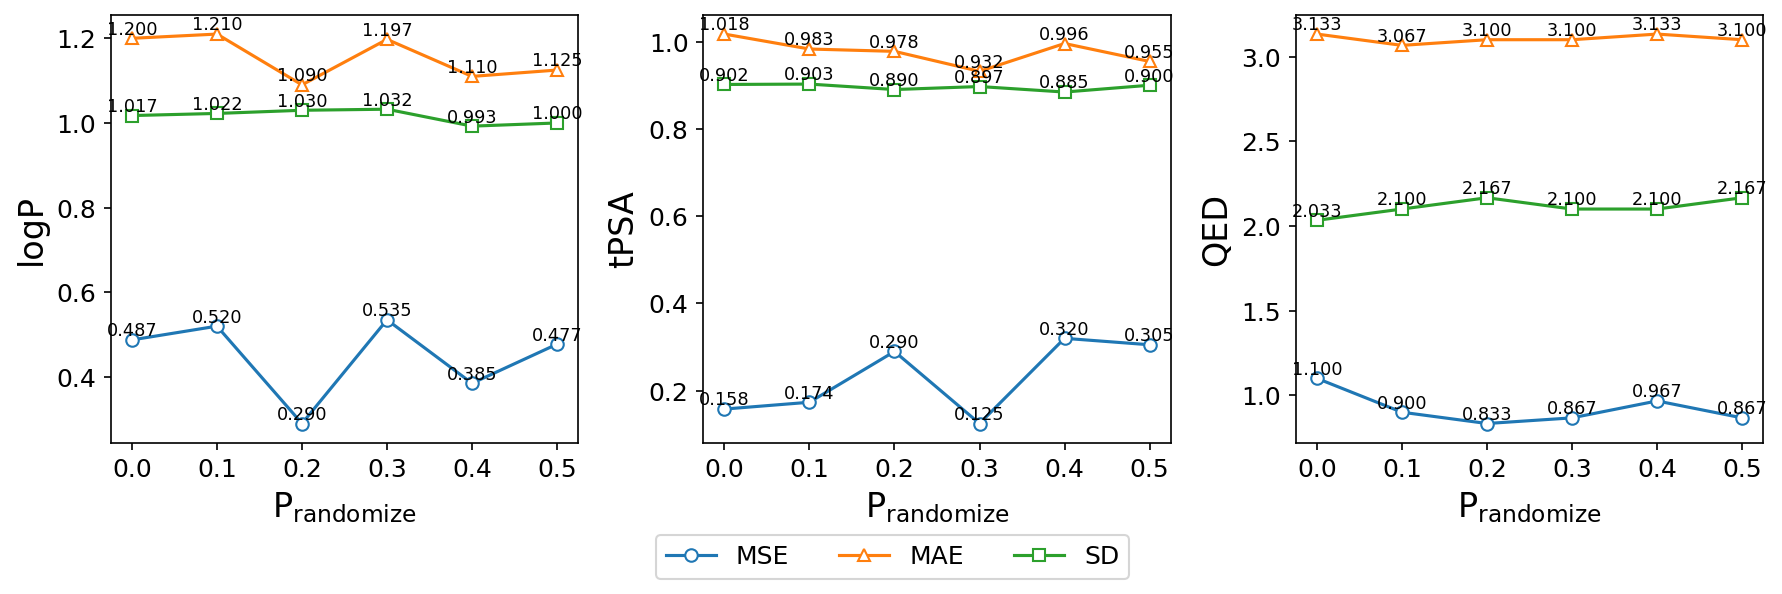

In [40]:
# Create the subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.7), dpi=150)

# Plot the line plots in the first subplot
ax1.plot(rand, log_mse, label='MSE', marker='o', markerfacecolor='white')
ax1.plot(rand, log_mae, label='MAE', marker='^', markerfacecolor='white')
ax1.plot(rand, log_sd, label='SD', marker='s', markerfacecolor='white')
ax1.set_xlabel(r'$\mathdefault{P}_{\mathdefault{randomize}}$', fontsize=16)
ax1.set_ylabel('logP', fontsize=16)
ax1.tick_params(axis='both', which='both', labelsize=12)
# ax1.legend(fontsize=12)

text_size = 8.5
for i in range(len(rand)):
    ax1.text(rand[i], log_mse[i], f'{log_mse[i]:.3f}', ha='center', va='bottom', fontsize=text_size)
    ax1.text(rand[i], log_mae[i], f'{log_mae[i]:.3f}', ha='center', va='bottom', fontsize=text_size)
    ax1.text(rand[i], log_sd[i], f'{log_sd[i]:.3f}', ha='center', va='bottom', fontsize=text_size)    

# Plot the line plots in the second subplot
ax2.plot(rand, tpsa_mse, label='MSE', marker='o', markerfacecolor='white')
ax2.plot(rand, tpsa_mae, label='MAE', marker='^', markerfacecolor='white')
ax2.plot(rand, tpsa_sd, label='SD', marker='s', markerfacecolor='white')
ax2.set_xlabel(r'$\mathdefault{P}_{\mathdefault{randomize}}$', fontsize=16)
ax2.set_ylabel('tPSA', fontsize=16)
ax2.tick_params(axis='both', which='both', labelsize=12)
# ax2.legend(fontsize=12)

for i in range(len(rand)):
    ax2.text(rand[i], tpsa_mse[i], f'{tpsa_mse[i]:.3f}', ha='center', va='bottom', fontsize=text_size)
    ax2.text(rand[i], tpsa_mae[i], f'{tpsa_mae[i]:.3f}', ha='center', va='bottom', fontsize=text_size)
    ax2.text(rand[i], tpsa_sd[i], f'{tpsa_sd[i]:.3f}', ha='center', va='bottom', fontsize=text_size)    

# Plot the line plots in the third subplot
ax3.plot(rand, qed_mse, label='MSE', marker='o', markerfacecolor='white')
ax3.plot(rand, qed_mae, label='MAE', marker='^', markerfacecolor='white')
ax3.plot(rand, qed_sd, label='SD', marker='s', markerfacecolor='white')
ax3.set_xlabel(r'$\mathdefault{P}_{\mathdefault{randomize}}$', fontsize=16)
ax3.set_ylabel('QED', fontsize=16)
ax3.tick_params(axis='both', which='both', labelsize=12)
# ax3.legend(fontsize=12)

for i in range(len(rand)):
    ax3.text(rand[i], qed_mse[i], f'{qed_mse[i]:.3f}', ha='center', va='bottom', fontsize=text_size)
    ax3.text(rand[i], qed_mae[i], f'{qed_mae[i]:.3f}', ha='center', va='bottom', fontsize=text_size)
    ax3.text(rand[i], qed_sd[i], f'{qed_sd[i]:.3f}', ha='center', va='bottom', fontsize=text_size)    

# Create a common legend at the bottom
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=12, ncol=3, bbox_to_anchor=(0.5, -0.08))

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

In [34]:
good_scaf = [569, 572, 557, 563, 582, 641]
good_prop = [94, 102, 103, 104, 103, 100]
good_both = [82, 89, 90, 90, 90, 89]

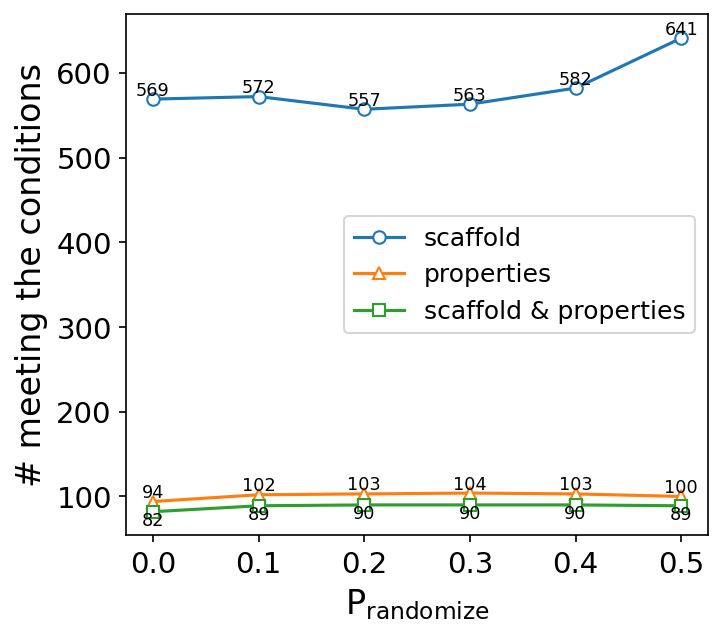

In [38]:
plt.figure(figsize=(5, 4.6), dpi=150)
plt.plot(rand, good_scaf, label='scaffold', marker='o', markerfacecolor='white')
plt.plot(rand, good_prop, label='properties', marker='^', markerfacecolor='white')
plt.plot(rand, good_both, label='scaffold & properties', marker='s', markerfacecolor='white')

for i in range(len(rand)):
    plt.text(rand[i], good_scaf[i], f'{good_scaf[i]:.0f}', ha='center', va='bottom', fontsize=text_size)
    plt.text(rand[i], good_prop[i], f'{good_prop[i]:.0f}', ha='center', va='bottom', fontsize=text_size)
    plt.text(rand[i], good_both[i], f'{good_both[i]:.0f}', ha='center', va='top', fontsize=text_size)    
# r'$\mathdefault{Valid}_{\mathdefault{seen}}$'
plt.xlabel(r'$\mathdefault{P}_{\mathdefault{randomize}}$', fontsize=16)
plt.ylabel('# meeting the conditions', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)

plt.show()

In [4]:
rand = np.arange(0, 0.6, 0.1)
smooth_start = [0.777, 0.770, 0.779, 0.773, 0.787, 0.771]
smooth_prev = [0.706, 0.632, 0.673, 0.674, 0.729, 0.650]

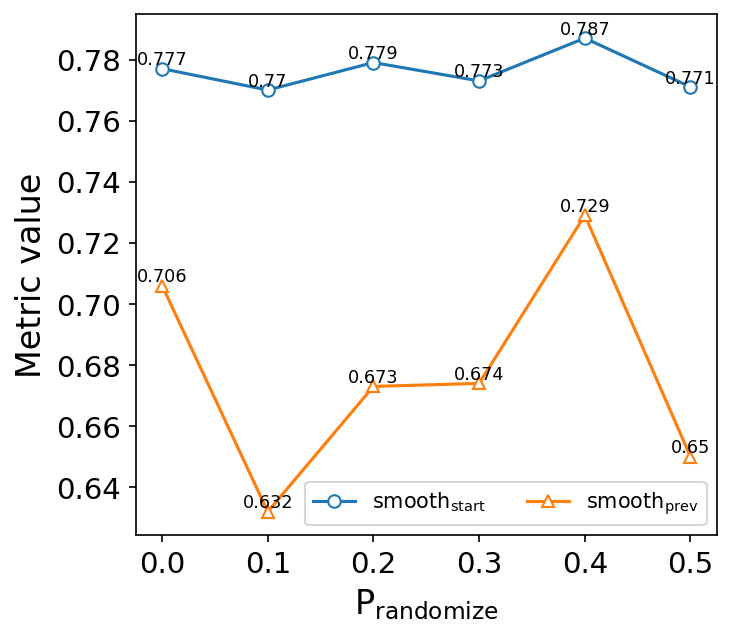

In [5]:

# plt.figure(figsize=(5, 4.6), dpi=150)

fig, ax = plt.subplots(figsize=(5, 4.6), dpi=150)


ax.plot(rand, smooth_start, label=r'$\mathdefault{smooth}_{\mathdefault{start}}$', marker='o', markerfacecolor='white')
ax.plot(rand, smooth_prev, label=r'$\mathdefault{smooth}_{\mathdefault{prev}}$', marker='^', markerfacecolor='white')

text_size = 8.5
for i in range(len(rand)):
    ax.text(rand[i], smooth_start[i], smooth_start[i], ha='center', va='bottom', fontsize=text_size)
    ax.text(rand[i], smooth_prev[i], smooth_prev[i], ha='center', va='bottom', fontsize=text_size)

plt.xlabel(r'$\mathdefault{P}_{\mathdefault{randomize}}$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=10, loc='lower right', ncol=3)

plt.show()

### Method

In [4]:
import numpy as np
import pandas as pd

# r'$\mathdefault{smooth}_{\mathdefault{start}}$'

In [7]:
constraint = ['X', 'P', r'S$_{\mathdefault{seen}}$', r'S$_{\mathdefault{unseen}}$',
              r'P+S$_{\mathdefault{seen}}$', r'P+S$_{\mathdefault{unseen}}$']

successful_valid = np.array([0.995, 0.421, 0.955, 0.928, 0.109, 0.084]) * 100
successful_unique = np.array([0.994, 0.372, 0.278, 0.205, 0.048, 0.030]) * 100


df = pd.DataFrame({
    r'$\mathdefault{Successful}_{\mathdefault{valid}}$': successful_valid,
    r'$\mathdefault{Successful}_{\mathdefault{unique}}$': successful_unique
}, index=constraint)

# df = pd.DataFrame({
#     '% condition-compliant (valid)': successful_valid,
#     '% condition-compliant (unique)': successful_unique
# }, index=constraint)


# novel_unique = np.array([0.792, 0.778, 0.291, 0.236, 0.337, 0.290]) * 100
# successful_rate = np.array([1, 0.4201, 0.9644, 0.9525, 0.108, 0.082]) * 100
# df = pd.DataFrame({
#     '% novel & unique molecules': novel_unique,
#     '% constraint-compliant molecules': successful_rate
# }, index=constraint)

df

,$\mathdefault{Successful}_{\mathdefault{valid}}$,$\mathdefault{Successful}_{\mathdefault{unique}}$
X,99.5,99.4
P,42.1,37.2
S$_{\mathdefault{seen}}$,95.5,27.8
S$_{\mathdefault{unseen}}$,92.8,20.5
P+S$_{\mathdefault{seen}}$,10.9,4.8
P+S$_{\mathdefault{unseen}}$,8.4,3.0


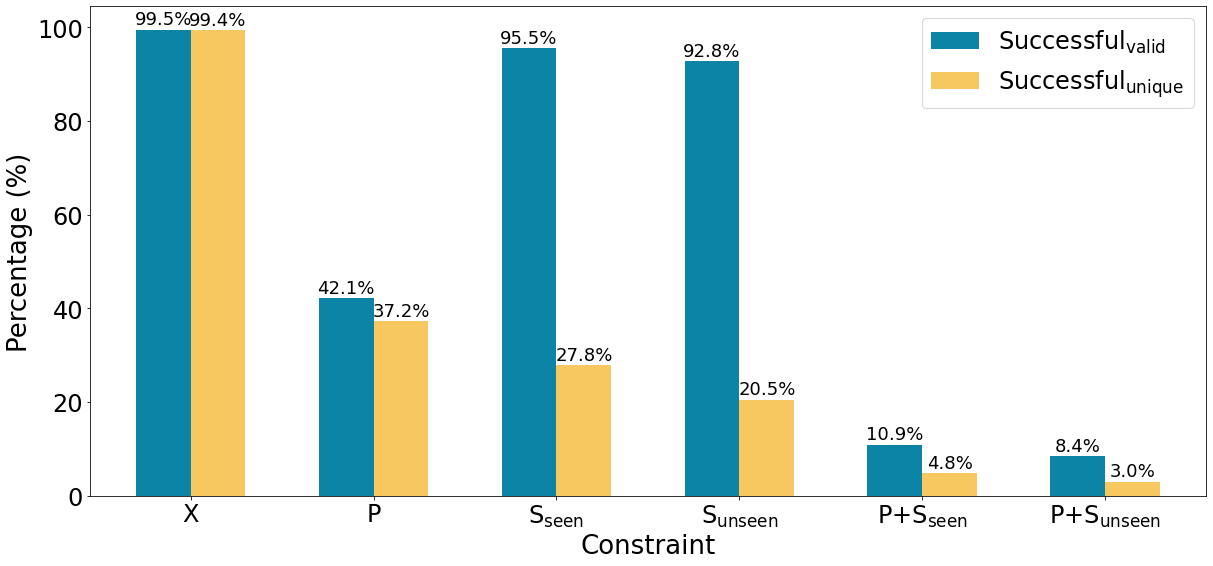

In [8]:
import numpy as np
import matplotlib.pyplot as plt

ax = df.plot.bar(figsize=(20, 9), rot=0, color=['#0b84a5', '#f6c85f'], width=0.6)

ax.set_xlabel('Constraint', fontsize=26)
ax.set_ylabel('Percentage (%)', fontsize=26)
ax.tick_params(axis='both', which='both', labelsize=24)
ax.legend(fontsize=24)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 5), textcoords='offset points', ha='center', fontsize=18, color='black')
    
# Display the plot
plt.show()